In [4]:
from pathlib import Path
import json
import torch
import sys
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from src.data.stocks import read_processed_data
from src.utils.checks import check_datatypes
from src.evaluation.plots import plot_train_valid_with_preds

from src.evaluation.plots import plot_interactive_predictions_with_slider, plot_error
from src.evaluation.utils import collect_predictions_per_timestamp
from src.evaluation.metrics import (
    calc_mse,
    calc_mae,
    calc_rmse,
    calc_mape,
    calc_directional_accuracy
)

from src.utils.config import load_config
from src.utils.path import get_project_root_path, verify_existing_dir, verify_saving_path, verify_file_path
import pandas as pd

In [5]:
config = load_config()

In [17]:
config['eval_config']['general']['results_save_path']

'./results/'

In [9]:
config['train_config']['model']['save_path']

'./models/'

In [4]:
from src.data.stocks import get_most_recent_processed_data_path

In [13]:
config['eval_config']['general']['results_save_path']

'./results/'

In [20]:
def plot_inference_results(y_train,
                           y_train_dates,
                           y_valid,
                           y_valid_dates,
                           y_pred,
                           y_pred_dates,
                           save_path=None,
                           save_filename=None):
    """
    Plot training, validation, and real-time prediction results using Plotly.

    This function generates an interactive time series plot of:
    - Training data
    - Validation data
    - Real-time predictions

    The plot can be displayed directly or saved as an HTML file.

    Parameters
    ----------
    y_train : array-like
        Training target values.
    y_train_dates : array-like
        Corresponding datetime values for `y_train`.
    y_valid : array-like
        Validation target values.
    y_valid_dates : array-like
        Corresponding datetime values for `y_valid`.
    y_pred : array-like
        Future value predictions.
    y_pred_dates : array-like
        Corresponding datetime values for `y_pred`.
    save_path : str or pathlib.Path or None, optional
        Directory where the HTML file should be saved. If None, the plot is shown in a browser.
    save_filename : str or None, optional
        Name of the output HTML file. If None, defaults to `'real_time_inference.html'`.

    Returns
    -------
    None
        Displays or saves the plot. Does not return any object.
    """

    check_datatypes([
        ("y_train", y_train, (np.ndarray, torch.Tensor, list, pd.Series)),
        ("y_train_dates", y_train_dates, (np.ndarray, torch.Tensor, list, pd.Series, pd.DatetimeIndex)),
        ("y_valid", y_valid, (np.ndarray, torch.Tensor, list, pd.Series)),
        ("y_valid_dates", y_valid_dates, (np.ndarray, torch.Tensor, list, pd.Series, pd.DatetimeIndex)),
        ("y_pred", y_pred, (np.ndarray, torch.Tensor, list, pd.Series)),
        ("y_pred_dates", y_pred_dates, (np.ndarray, torch.Tensor, list, pd.Series, pd.DatetimeIndex)),
        ("save_path", save_path, (str, Path, type(None))),
        ("save_filename", save_filename, (str, type(None)))
    ])

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=y_train_dates,
        y=y_train,
        mode='lines',
        name='Train',
        line=dict(color='#737e8c')
    ))

    fig.add_trace(go.Scatter(
        x=y_valid_dates,
        y=y_valid,
        mode='lines',
        name='Validation',
        line=dict(color='#1f77b4')
    ))

    fig.add_trace(go.Scatter(
        x=y_pred_dates,
        y=y_pred,
        mode='lines',
        name='Real-time Predictions',
        line=dict(color='#dc2330')
    ))

    fig.update_layout(
        title='Training, Validation, and Real-time Predictions',
        xaxis_title='Date',
        yaxis_title='Value',
        height=500,
        width=1200,
        template='plotly_white',
        legend=dict(x=0, y=1),
        hovermode='x unified'
    )

    # Save plot to HTML
    if save_path is not None:
        if not save_filename:
            save_filename = str(save_path / f"real_time_inference.html")
        fig.write_html(save_filename, include_plotlyjs='cdn')
        import json
        from plotly.utils import PlotlyJSONEncoder
        with open(str(save_path / f"plot.json"), "w") as f:
            json.dump(fig, f, cls=PlotlyJSONEncoder)
        print(str(save_path / f"plot.json"))
        print(f"[Saved] Plot saved to: {save_filename}")
        return

    # Show the plot in the browser
    fig.show()

In [21]:

def get_inference_results():

    # Load the config
    config = load_config()

    # Get the save path for the results from the config
    predictions_folder_path = config['deploy_config']['paths']['predictions_save_path']
    predictions_folder_path = ".." / Path(predictions_folder_path)

    verify_existing_dir(predictions_folder_path)

    # Get the results save path
    prediction_results_folder_path = config['eval_config']['general']['results_save_path']
    prediction_results_folder_path = ".." / Path(prediction_results_folder_path)

    verify_existing_dir(prediction_results_folder_path)
    
    # Get the most recent processed saved data path from the config
    stock_data_processed_data_path = ".." / Path(config['stock']['stock_data_processed_save_path'])
    most_recent_processed_data_path = get_most_recent_processed_data_path(stock_data_processed_data_path)

    # Get the valid stock folders
    stock_folders = [stock_folder for stock_folder in predictions_folder_path.iterdir() if stock_folder.is_dir()]

    for stock_folder in stock_folders:
        ticker = stock_folder.stem
        print(ticker)
        ticker_processed_data_path = most_recent_processed_data_path / ticker
        predictions_file = Path(config['deploy_config']['paths']['predictions_file'])
        path_to_average_predictions = stock_folder / predictions_file.with_name(f"{predictions_file.stem}_averaged.csv")
        
        predictions_averaged = pd.read_csv(path_to_average_predictions)

        X_train, X_valid, y_train, y_valid, y_train_dates, y_valid_dates = read_processed_data(ticker_processed_data_path)

        # Convert all date strings to datetime
        y_train_dates = pd.to_datetime(y_train_dates)
        y_valid_dates = pd.to_datetime(y_valid_dates)
        predictions_averaged['prediction_for_date'] = pd.to_datetime(predictions_averaged['prediction_for_date'])

        # Ticker save folder
        inference_results_save_path = prediction_results_folder_path / ticker
        verify_saving_path(inference_results_save_path)

        # Save the real-time stock plot
        plot_inference_results(y_train=y_train[:, 0],
                               y_train_dates=y_train_dates,
                               y_valid=y_valid[:, 0],
                               y_valid_dates=y_valid_dates,
                               y_pred=predictions_averaged["prediction"],
                               y_pred_dates=predictions_averaged["prediction_for_date"],
                               save_path=inference_results_save_path
                              )

        

In [22]:
get_inference_results()

AAPL
../results/AAPL/plot.json
[Saved] Plot saved to: ../results/AAPL/real_time_inference.html
GOOGL
../results/GOOGL/plot.json
[Saved] Plot saved to: ../results/GOOGL/real_time_inference.html


In [18]:
# Convert all date strings to datetime
y_train_dates = pd.to_datetime(y_train_dates)
y_valid_dates = pd.to_datetime(y_valid_dates)
predictions_averaged['prediction_for_date'] = pd.to_datetime(predictions_averaged['prediction_for_date'])

In [52]:
pd.Series([1,2,3])

pandas.core.series.Series

In [49]:
type(y_train_dates)

pandas.core.indexes.datetimes.DatetimeIndex

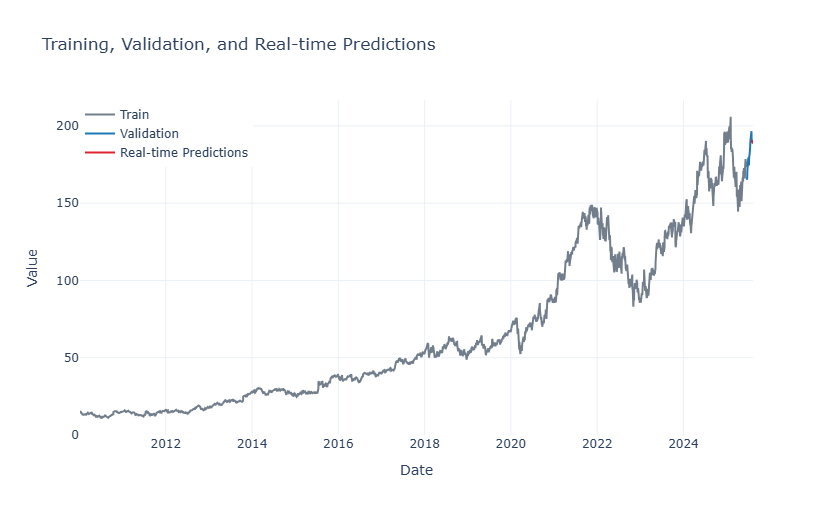

In [44]:
plot_inference_results(y_train[:, 0], y_train_dates, y_valid[:, 0], y_valid_dates, predictions_averaged.rename({"prediction_for_date": "date"}, axis=1))

In [45]:
y_train_dates

DatetimeIndex(['2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19',
               ...
               '2025-06-05', '2025-06-06', '2025-06-09', '2025-06-10',
               '2025-06-11', '2025-06-12', '2025-06-13', '2025-06-16',
               '2025-06-17', '2025-06-18'],
              dtype='datetime64[ns]', length=3888, freq=None)

In [13]:
X_train, X_valid, y_train, y_valid = read_processed_data("../data/processed_data/2025-07-30/target_AAPL")

In [16]:
x = np.array([1,2,3])
y = np.array([1,2,3])

In [ ]:
np.concatenate([x,y])

In [ ]:
get_train_results()

In [100]:
plot_error(y_train[:, 0].numpy(), metric="MAE", split_point=3500)

In [9]:
import plotly.io as pio
pio.renderers.default = 'notebook'

In [10]:
plot_interactive_predictions_with_slider(y_train[:, 0], y_valid[:, 0], predictions_list)

[Saved] Plot saved to: predictions_plot.html


In [82]:
y_train[:, 0]

tensor([ 15.5223,  15.1310,  14.7787,  ..., 177.3500, 175.7000, 174.6700])

In [104]:
model_name = "2025_08_01_23_07_42"
model_path = f"../models/{model_name}/AAPL"
model_data_date = "-".join(model_name.split("_")[:3])
data_path = f"../data/processed_data/{model_data_date}/target_AAPL"

In [123]:
def get_future_predictions(model_folder, data_path):
    """
    Load the latest TorchScript model and make predictions using the most recent input data.

    Args:
        model_folder (str or Path): Path to the folder containing model files named like 'model_*.pt'.
        data_path (str or Path): Path to the directory containing 'last_row.pt' with the latest input data.

    Returns:
        tuple:
            - prediction_date (str): The date corresponding to the input row used for prediction.
            - predictions (torch.Tensor): The model's predicted values, detached from the computation graph.
    
    """
    
    # Check the inputs
    check_datatypes([
        ("model_folder", model_folder, (str, Path)),
        ("data_path", data_path, (str, Path))
    ])

    # Convert the paths to Path object
    model_folder = Path(model_folder)
    data_path = Path(data_path) 

    # Read the model 
    model_path = sorted(model_folder.glob("model_*.pt"))[-1]
    model = torch.jit.load(model_path)

    # Read the latest date and the input (to use for real-time predictions)
    data_file = data_path / "last_row.pt"
    prediction_date_input_dict = torch.load(data_file)

    # Get the predictions from the input
    prediction_date, X = next(iter(prediction_date_input_dict.items()))
    predictions = model(X)
    
    return prediction_date, predictions.detach()

In [150]:
prediction_date, predictions = get_future_predictions(model_path, data_path)

In [151]:
x, y = append_prediction_metadata(
    predictions=predictions[0],
    prediction_date=prediction_date,
    model_name=model_name,
    predictions_data_path="./au",
    predictions_log_path="./au"
)

In [152]:
x

,prediction_done,prediction_for_date,horizon,prediction,model_name
0,2025-08-01,2025-08-02,1,202.076187,2025_08_01_23_07_42
1,2025-08-01,2025-08-03,2,203.277557,2025_08_01_23_07_42
2,2025-08-01,2025-08-04,3,203.505463,2025_08_01_23_07_42
3,2025-08-01,2025-08-05,4,204.319214,2025_08_01_23_07_42
4,2025-08-01,2025-08-06,5,203.646744,2025_08_01_23_07_42
5,2025-08-01,2025-08-07,6,203.219742,2025_08_01_23_07_42
6,2025-08-01,2025-08-08,7,202.899139,2025_08_01_23_07_42


In [154]:
Path("ad/sdf.png").with_name("asd.png")

PosixPath('ad/asd.png')

In [153]:
y

,prediction_date,prediction_saved,forecast_horizon
0,2025-08-01,True,7


In [119]:
prediction_date

'2025-08-01'

In [84]:
from src.data.stocks import read_and_concat_all_stocks

In [85]:
x = read_and_concat_all_stocks("../data/raw_stocks")

In [93]:
import pandas as pd

In [ ]:
def predict()

In [ ]:
def check_missing_predictions(latest_date_to_check, predictions_log_file_path):
    predictions_log_file_path = Path(predictions_log_file_path)
    if not predictions_log_file_path.exists():
        predictions_log = pd.DataFrame()
    pd.read_csv("")
    
    